Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [4]:
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)
train.shape, val.shape

((47520, 41), (11880, 41))

In [0]:
import numpy as np

def calculate_distance(lat1, lon1, lat2, lon2):
    # Formula to calculate distance in KM between two points using lattitude 
    # and longitude.

    R = 6373 # Radius of earth in km
    lat1 = np.deg2rad(lat1)
    lat2 = np.deg2rad(lat2)
    lon1 = np.deg2rad(lon1)
    lon2 = np.deg2rad(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

cities_dict = {
    'Dar es Salaam' : [-6.8, 39.283333],
    'Mwanza' : [-2.516667, 32.9],
    'Arusha' : [-3.366667, 36.683333],
    'Mbeya' : [-8.9, 33.45],
    'Morogoro' : [-6.824167, 37.663333],
    'Tanga' : [-5.066667, 39.1],
    'Kahama' : [-3.8375, 32.6],
    'Tabora' : [-5.016667, 32.8],
    'Zanzibar City' : [-6.165, 39.199],
    'Kigoma' : [-4.883333, 29.633333],
    'Dodoma' : [-6.173056, 35.741944],
    'Sumbawanga' : [-7.966667, 31.616667],
    'Kasulu' : [4.58, 30.1],
    'Songea' : [-10.683333, 35.65],
    'Moshi' : [-3.334883, 37.340381],
    'Musoma' : [-1.5, 33.8],
    'Shinyanga' : [-3.661944, 33.423056],
    'Iringa' : [-7.766667, 35.7],
    'Singida' : [-4.816667, 34.75],
    'Njombe' : [-9.333333, 34.766667],
    }

def closest_city(data):

    lat = data[0]
    lon = data[1]
    try:
        if np.isnan(lat) or np.isnan(lon):
            return np.nan, np.nan
    except:
        return np.nan, np.nan

    min_distance = 99999
    closest_city = ''
    for key in cities_dict.keys():
        distance = calculate_distance(lat, lon, 
                                      cities_dict[key][0], cities_dict[key][1])
        if distance < min_distance:
            min_distance = distance
            closest_city = key

    return closest_city, min_distance

def get_closest_city_name(data):
    name, _ = closest_city(data)
    return name

def get_closest_city_distance(data):
    _, distance = closest_city(data)
    return distance

def years(data):
    if pd.isna(data[1]):
        return np.nan
    else:
        return (data[0] - data[1].dt.year)

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)

    # convert date_recorded to datetime format
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')

    # reduce cardinality:
    high_cardinality_features = ['installer', 'funder', 'region', 
                                 'management']
    for n in high_cardinality_features:
        top10 = X[n].value_counts()[:15].index
        X.loc[~X[n].isin(top10), n] = 'OTHER' 

    # create two new features:
    X['closest_city'] = X[['latitude', 'longitude']].apply(get_closest_city_name, axis=1)
    X['closest_city_distance'] = X[['latitude', 'longitude']].apply(get_closest_city_distance, axis=1)
    X['years'] = X['year_recorded'] - X['construction_year']

    # drop some stuff
    X = X.drop(columns='year_recorded')
    X = X.drop(columns='month_recorded')
    X = X.drop(columns='day_recorded')

    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [6]:
train.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,closest_city,closest_city_distance,years
43360,72938,0.0,OTHER,0,OTHER,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,NaN,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,Mbeya,32.222060,NaN
7263,65358,500.0,OTHER,2049,OTHER,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008.0,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,Njombe,11.413647,3.0
2486,469,25.0,OTHER,290,OTHER,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010.0,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,Morogoro,95.793599,1.0
313,1298,0.0,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,other,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,Mwanza,278.480769,NaN
52726,27001,0.0,OTHER,0,OTHER,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,NaN,mono,mono,motorpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,Dodoma,46.440557,NaN


In [7]:
# The status_group column is the target
target = 'status_group'

# Stuff I don't think is gonna be useful:
not_useful = ['num_private', 'construction_year', 'gps_height', 'amount_tsh',
              'scheme_name', 'recorded_by']

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'] + not_useful)

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 100].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

print(len(features), "features selected")

29 features selected


In [10]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=0)
    )

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    # 'randomforestclassifier__random_state' = [0, 5, 10, 15, 20],
    'randomforestclassifier__n_estimators': [50, 100, 300, 500], 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, 25, None], 
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__min_samples_split': [2, 3, 4, 5]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-2
)

search.fit(X_train, y_train)

pipeline = search.best_estimator_
print(pipeline.score(X_val, y_val))

# Wake me up when it's done... zzz...
from google.colab import output
output.eval_js('new Audio("https://vignette.wikia.nocookie.net/finalfantasy/images/d/db/FFXV_Victory_Fanfare.ogg").play()')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.954, test=0.808), total=  26.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   31.5s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.954, test=0.803), total=  25.8s


[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.954, test=0.811), total=  26.1s


[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s


[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.953, test=0.806), total=  26.0s


[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s


[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13364341595384888, randomforestclassifier__min_samples_split=5, randomforestclassifier__n_estimators=500, simpleimputer__strategy=median, score=(train=0.954, test=0.803), total=  26.3s


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s


[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean, score=(train=0.684, test=0.687), total=   6.2s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean 


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:  2.8min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean, score=(train=0.680, test=0.676), total=   6.4s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean 


[Parallel(n_jobs=-2)]: Done   7 out of   7 | elapsed:  2.9min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean, score=(train=0.677, test=0.682), total=   6.4s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean 


[Parallel(n_jobs=-2)]: Done   8 out of   8 | elapsed:  3.0min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean, score=(train=0.681, test=0.680), total=   6.3s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean 


[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:  3.2min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.0552032012184559, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500, simpleimputer__strategy=mean, score=(train=0.682, test=0.676), total=   6.4s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13331314566551544, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=100, simpleimputer__strategy=mean 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13331314566551544, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=100, simpleimputer__strategy=mean, score=(train=0.970, test=0.805), total=   6.0s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.13331314566551544, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=100, simpleimputer__strategy=mean 
[CV]  randomforestclassifier

[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed: 26.2min finished


0.8143097643097643


In [11]:
pipeline = search.best_estimator_
print(pipeline.score(X_val, y_val))

0.8143097643097643


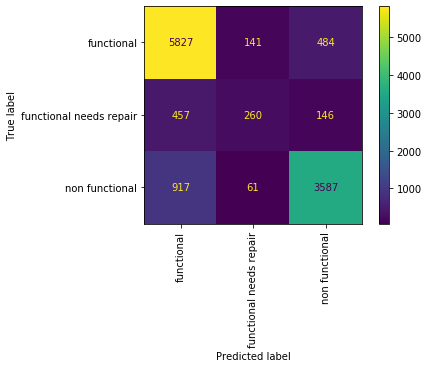

In [13]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

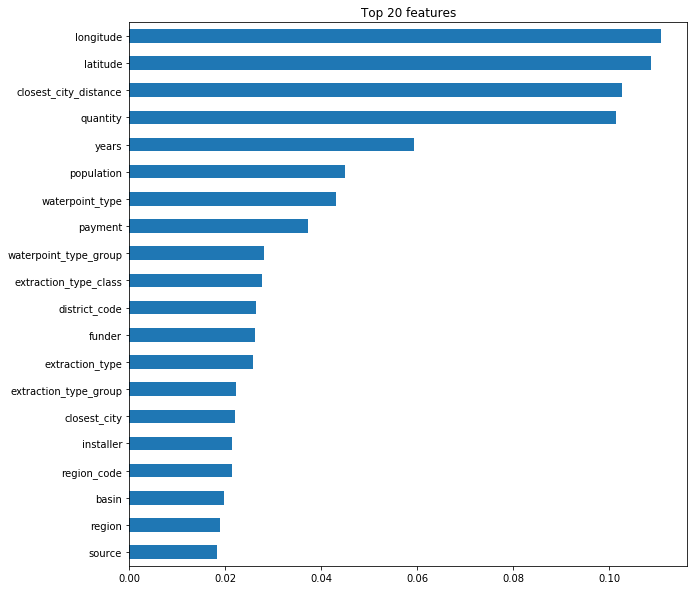

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(train[features])

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [0]:
# Save test results as a .csv:
test['status_group'] = pipeline.predict(test[features])
test[['id', 'status_group']].to_csv('submission.csv', index=False)